# 1. Data Wrangling
## a. Import required libraries

In [28]:
import pandas as pd
from sqlalchemy import create_engine,text
import seaborn as sns 
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt


%matplotlib inline


## b. Viewing the structure of the data 

In [8]:
sales = pd.read_csv('Coffee_Shop_Sales.csv')
sales.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,1/1/2023,7:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,1/1/2023,7:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,1/1/2023,7:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,1/1/2023,7:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,1/1/2023,7:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [19]:
print(f"Shape of data: {sales.shape}  \n \n Columns in data: \n {sales.columns}")

Shape of data: (137156, 11)  
 
 Columns in data: 
 Index(['transaction_id', 'transaction_date', 'transaction_time',
       'transaction_qty', 'store_id', 'store_location', 'product_id',
       'unit_price', 'product_category', 'product_type', 'product_detail'],
      dtype='object')


In [4]:
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
transaction_id,137156.0,68743.638368,39694.721778,1.0,34345.75,68747.5,103120.25,137492.0
transaction_qty,137156.0,1.433288,0.536371,1.0,1.00,1.0,2.00,8.0
store_id,137156.0,5.348880,2.074755,3.0,3.00,5.0,8.00,8.0
product_id,137156.0,47.919901,17.925812,1.0,34.00,47.0,60.00,87.0
unit_price,137156.0,3.387129,2.672210,0.8,2.50,3.0,3.75,45.0


In [6]:

sales = sales.drop_duplicates()
sales = sales.dropna()


In [24]:
sales['transaction_date'] = pd.to_datetime(sales['transaction_date']) # Date properly formatted

# SQL

After some initial cleanup, I transferred the data to a postgreSQL db to get a better understanding of the data and its trends.

I fed the data into the DB via a staging table.
There were pricing discrepancies for certain products and since the data was synthetic it just meant a fault in data generation so I  fixed it by updating the price on each erroneous category by the price that was used the most for that specific item.

Then once I made sure that the data was good to go, I normalised the data across the db into 3 tables:
- products
- stores
- transactions


I then exported the data as a clean csv

In [26]:
sales_cleaned = pd.read_csv('coffee_sales_cleaned.csv')
sales_cleaned

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,1/1/2023,7:06:11,2,5,Lower Manhattan,32,3.00,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,1/1/2023,7:08:56,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,1/1/2023,7:14:04,2,5,Lower Manhattan,59,4.50,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,1/1/2023,7:20:24,1,5,Lower Manhattan,22,2.00,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,1/1/2023,7:22:41,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
...,...,...,...,...,...,...,...,...,...,...,...
137151,137488,6/20/2023,10:58:31,1,5,Lower Manhattan,33,3.50,Coffee,Gourmet brewed coffee,Ethiopia Lg
137152,137489,6/20/2023,10:59:11,3,5,Lower Manhattan,87,3.00,Coffee,Barista Espresso,Ouro Brasileiro shot
137153,137490,6/20/2023,10:59:17,1,5,Lower Manhattan,23,2.50,Coffee,Drip coffee,Our Old Time Diner Blend Rg
137154,137491,6/20/2023,10:59:20,2,8,Hell's Kitchen,39,4.25,Coffee,Barista Espresso,Latte Rg


## Running queries on the cleaned data 
I connected to my postgres db and ran some queries to obtain all sorts of data

I could also have used something like duckdb, but I preferred doing it this way. 

In [29]:
load_dotenv()
DATABASE_URL = f"postgresql://{os.getenv("DB_USER")}:{os.getenv("DB_PWD")}@{os.getenv("DB_HOST")}:{os.getenv("DB_PORT")}/{os.getenv("DB_NAME")}"

engine = create_engine(DATABASE_URL)
conn = engine.connect()
trans = engine.begin()


In [42]:
conn.rollback()
daily_sales = pd.read_sql_query('''SELECT DATE(transaction_date) AS day,SUM(unit_price * transaction_qty) AS revenue,COUNT(DISTINCT transaction_id) as orders
                                FROM transactions t
                                JOIN products p ON p.product_id=t.product_id
                                GROUP BY day
                                ORDER BY day;''',conn)
daily_sales.describe().T

,count,mean,std,min,25%,50%,75%,max
revenue,171.0,3792.590702,1145.002931,2072.12,2869.315,3427.59,4702.2,6475.96
orders,171.0,802.081871,237.826789,459.00,591.000,731.00,1025.5,1343.00


In [60]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['figure.figsize'] = (24,10)

Text(0.5, 1.0, 'Daily Orders')

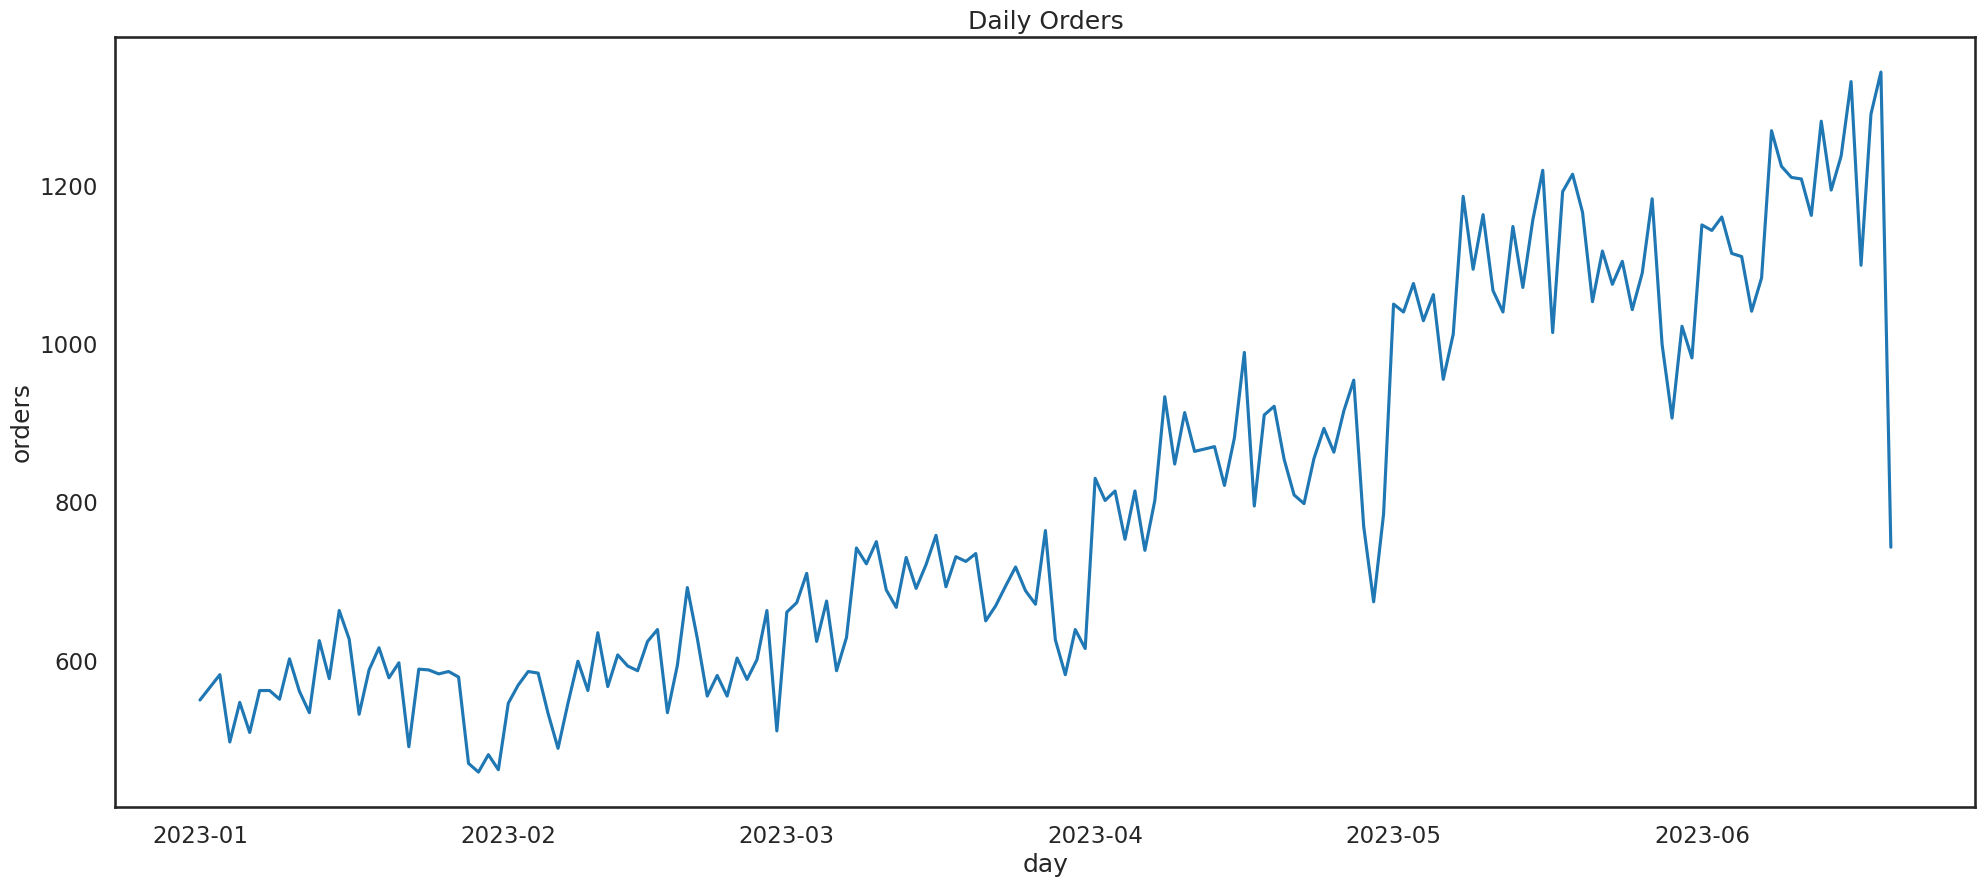

In [61]:
sns.set_style(style='white')
sns.set_context('talk')
sns.lineplot(x=daily_sales['day'],y=daily_sales['orders'])
plt.title("Daily Orders")


<Axes: xlabel='day', ylabel='revenue'>

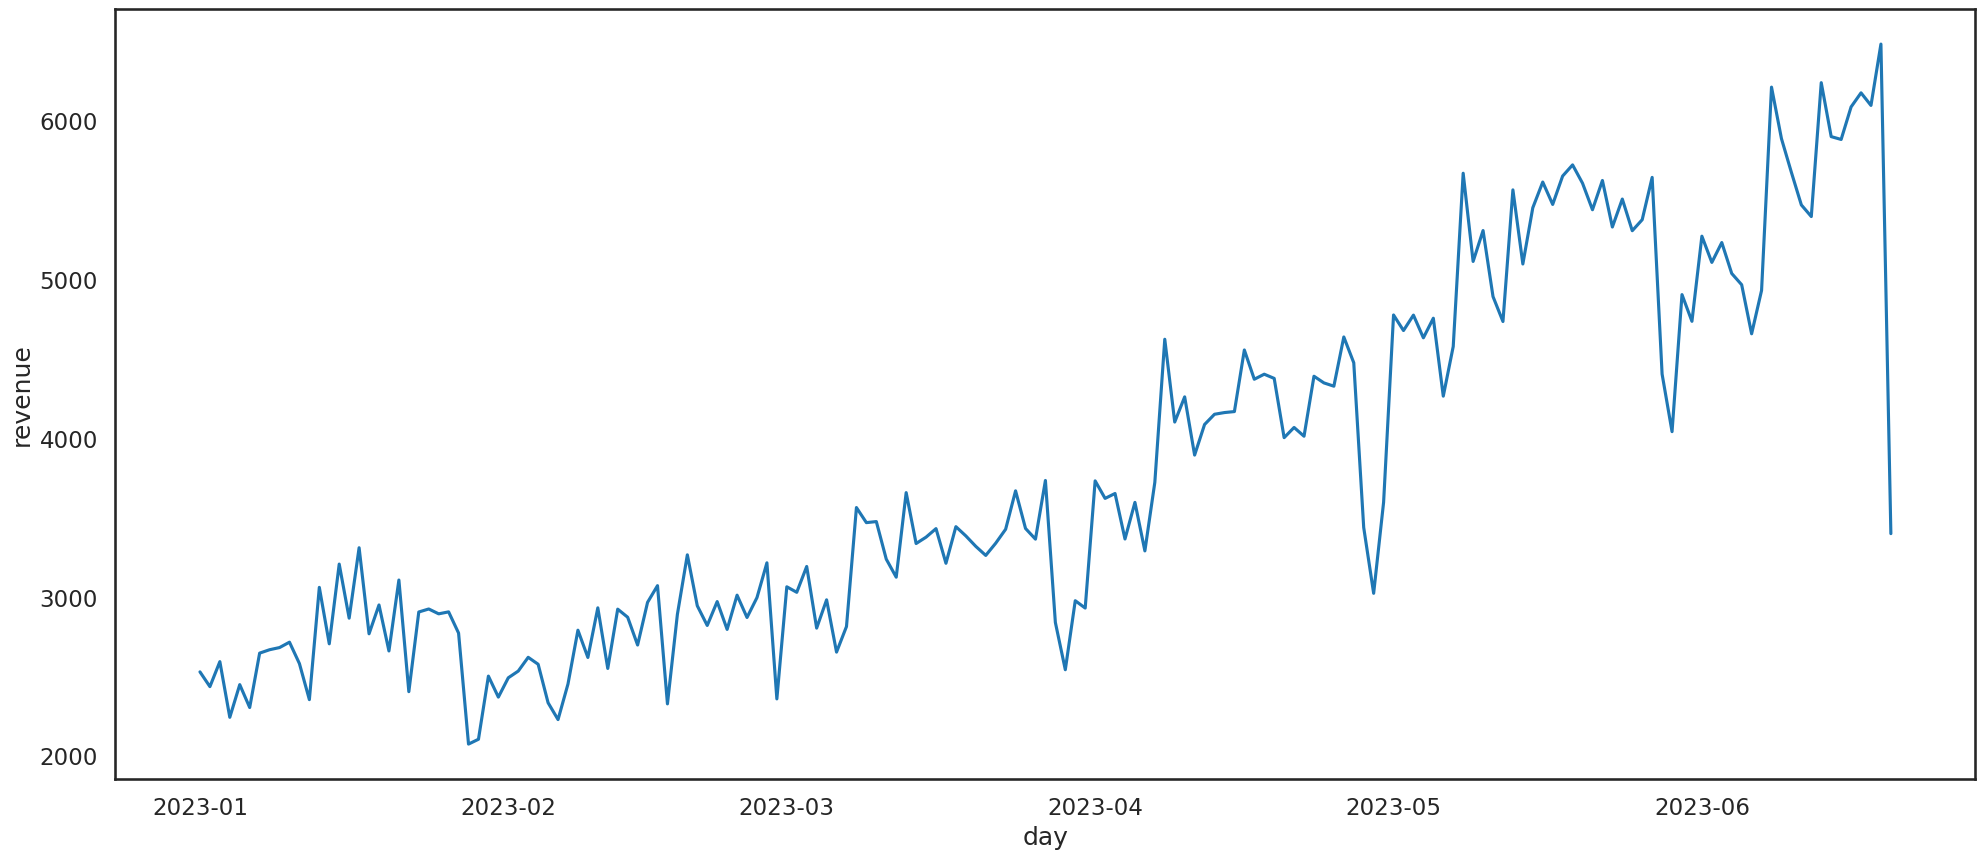

In [67]:
sns.set_context('talk')
sns.lineplot(data=daily_sales,x='day',y='revenue')


In [76]:
conn.rollback()
total_revenue_all = pd.read_sql_query('''SELECT EXTRACT(month FROM t.transaction_date) AS month,SUM(p.unit_price * transaction_qty) AS revenue
                                                 FROM transactions t
                                                 JOIN products p ON p.product_id=t.product_id
                                                 GROUP BY month
                                                 ORDER BY month;''',conn)

<Axes: xlabel='month', ylabel='revenue'>

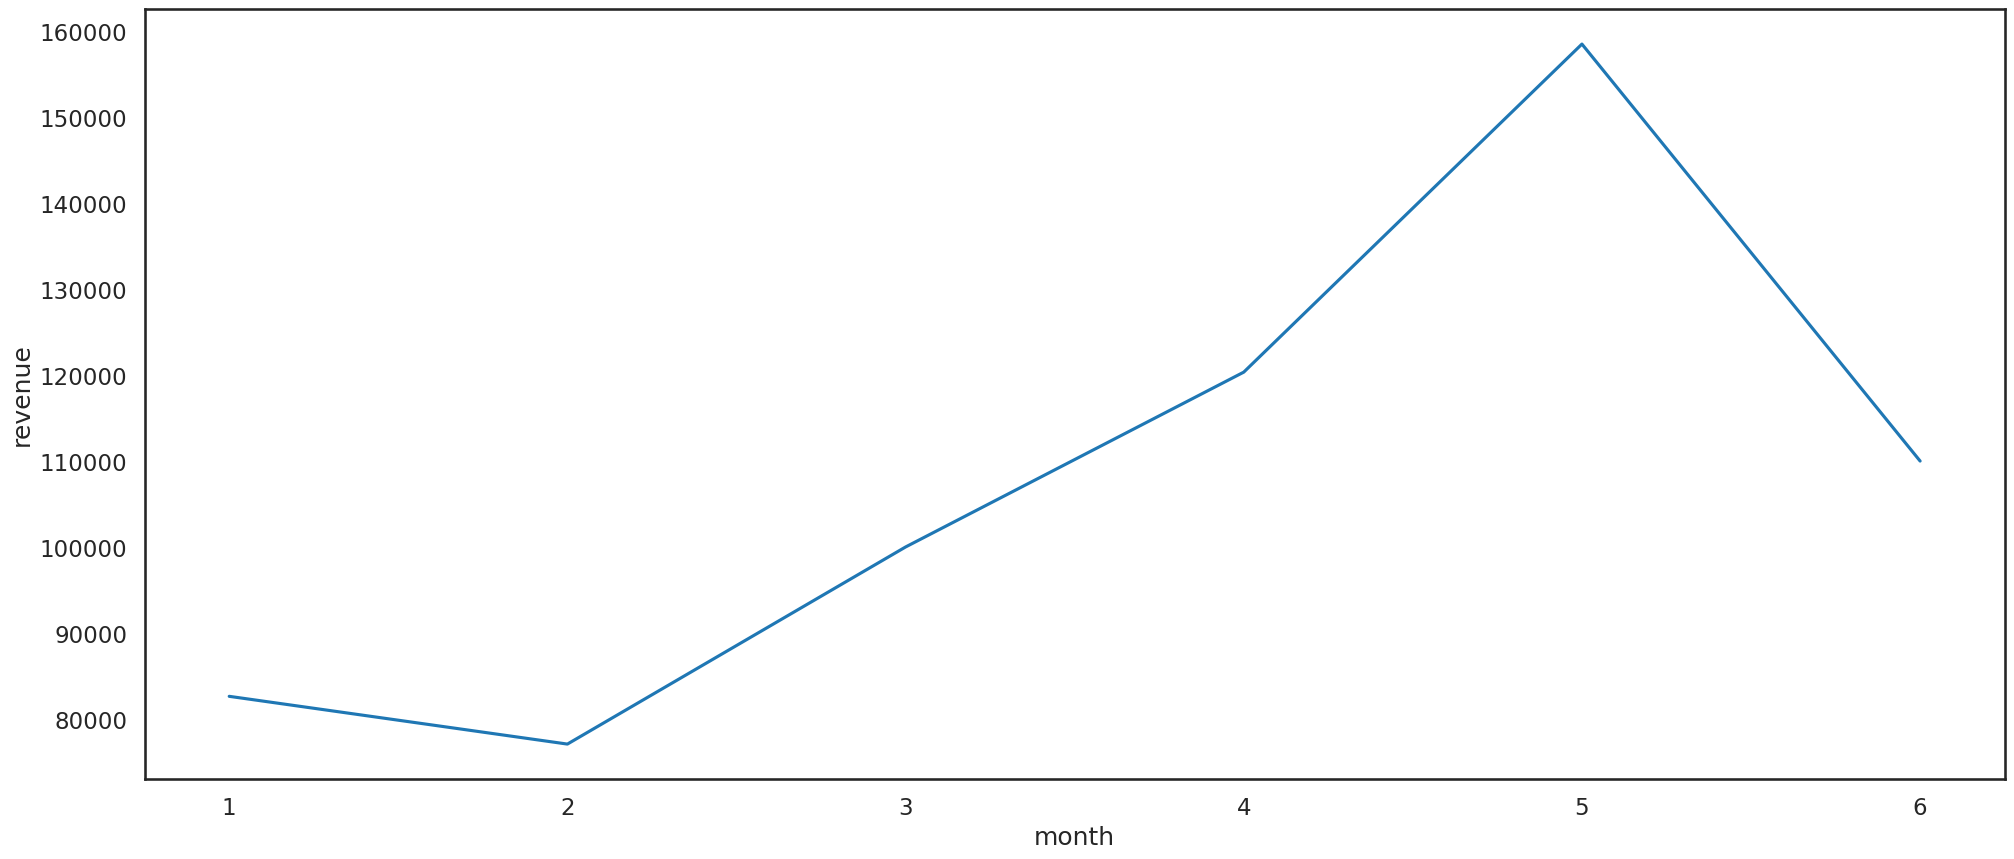

In [77]:
sns.set_context('talk')

sns.lineplot(data=total_revenue_all,x='month',y='revenue')


In [83]:
conn.rollback()
cat_rev_share = pd.read_sql_query('''SELECT 
    p.product_category,
    SUM(unit_price * transaction_qty) AS category_total,
    ROUND(
        100.0 * SUM(unit_price * transaction_qty) / 
        SUM(SUM(unit_price * transaction_qty)) OVER (), 
        2
    ) AS category_share_percent
FROM transactions t
JOIN products p ON t.product_id = p.product_id
GROUP BY p.product_category
ORDER BY category_share_percent DESC;''',conn)
cat_rev_share


,product_category,category_total,category_share_percent
0,Coffee,247297.65,38.13
1,Tea,180055.00,27.76
2,Bakery,82506.13,12.72
3,Drinking Chocolate,66388.50,10.24
4,Coffee beans,37294.85,5.75
5,Branded,12548.00,1.93
6,Loose Tea,10457.75,1.61
7,Flavours,7833.60,1.21
8,Packaged Chocolate,4151.53,0.64


<Axes: xlabel='product_category', ylabel='category_share_percent'>

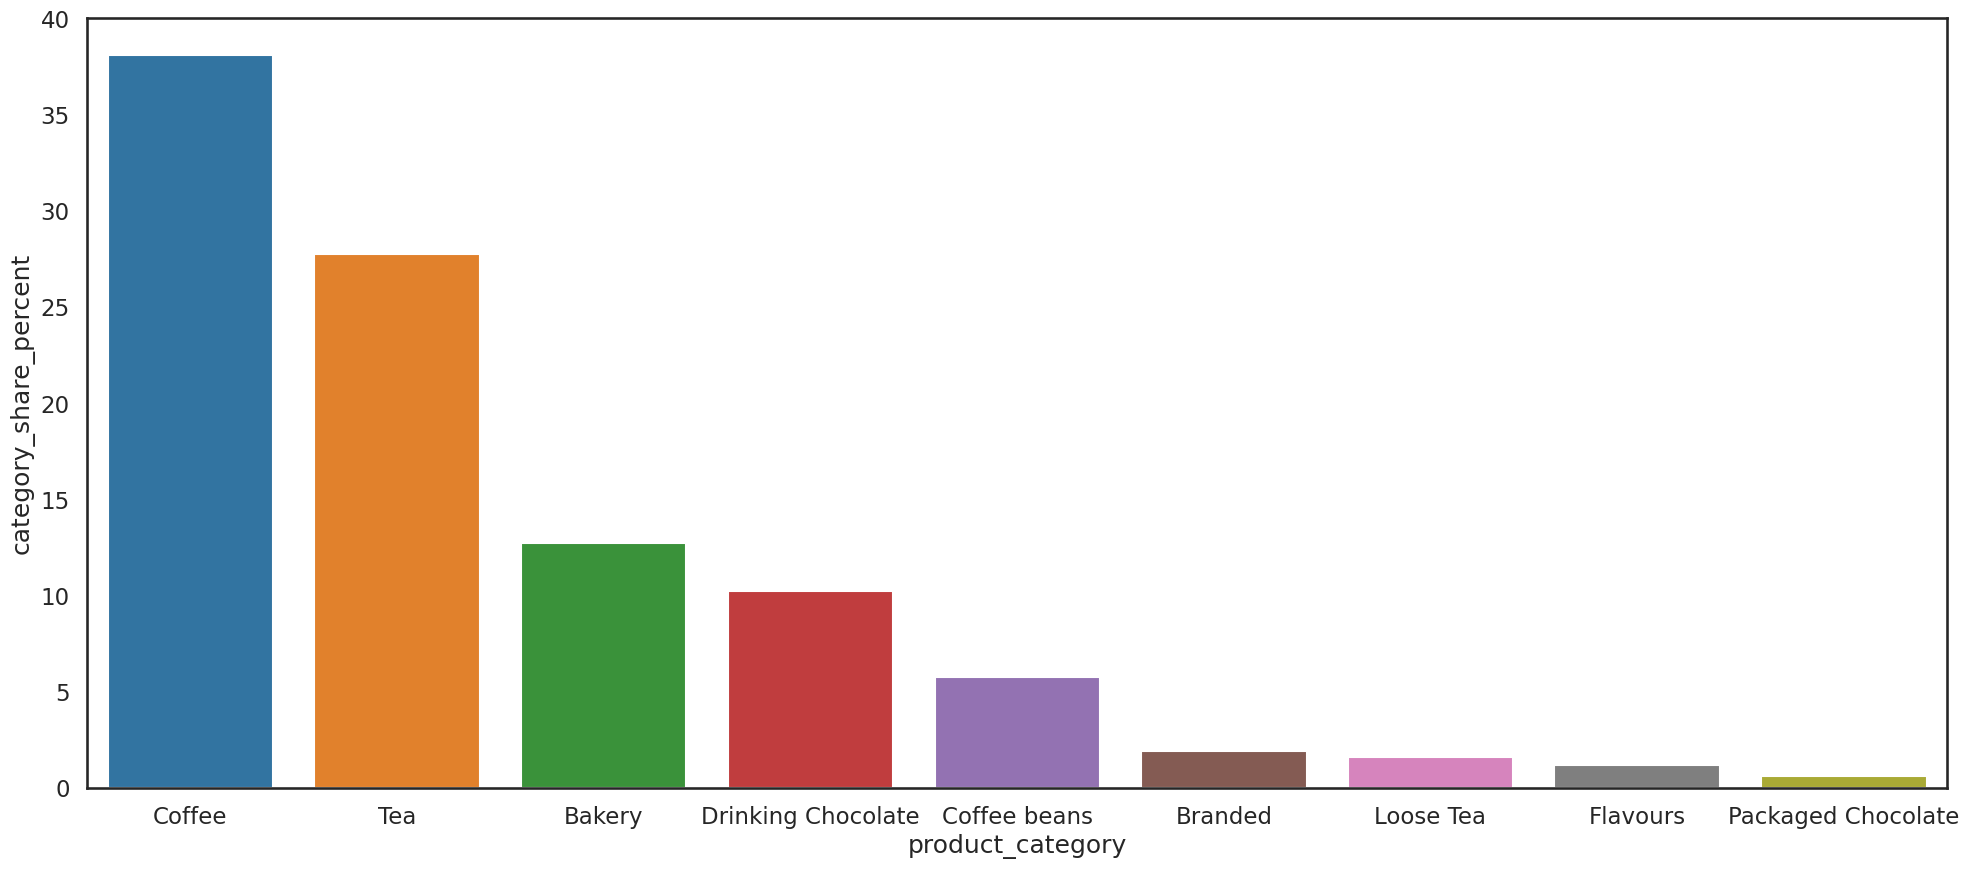

In [82]:
sns.barplot(data=cat_rev_share,x='product_category',y='category_share_percent',hue='product_category')

In [84]:
revenue_by_loc = pd.read_sql_query('''SELECT t.store_id,SUM(p.unit_price * transaction_qty) AS revenue,EXTRACT(month FROM transaction_date) AS month
FROM transactions t
JOIN products p ON p.product_id=t.product_id
GROUP BY t.store_id,month
ORDER BY month;''',conn)
revenue_by_loc

,store_id,revenue,month
0,8,28174.12,1.0
1,3,27541.94,1.0
2,5,26903.53,1.0
3,8,26047.17,2.0
4,5,25664.03,2.0
5,3,25351.28,2.0
6,8,33553.80,3.0
7,5,33291.71,3.0
8,3,33151.93,3.0
9,5,39704.63,4.0


<Axes: xlabel='month', ylabel='revenue'>

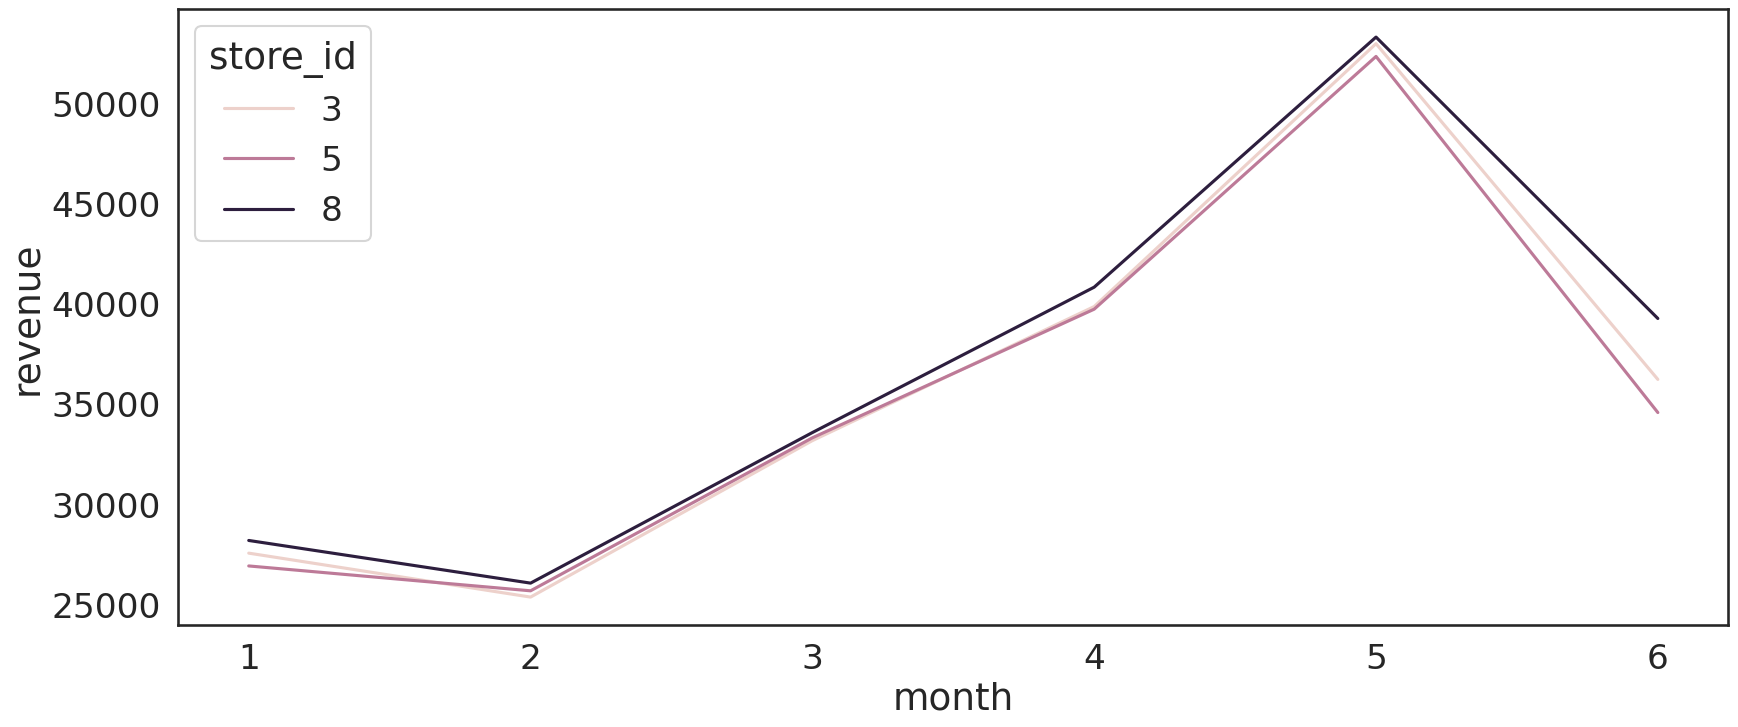

In [86]:
plt.figure(figsize=(20,8))
sns.set_context('talk',font_scale=1.5)
sns.lineplot(data=revenue_by_loc,x='month',y='revenue',hue='store_id',legend=True)

In [88]:
conn.rollback()
aov = pd.read_sql_query('''SELECT EXTRACT(month FROM transaction_date) AS month,SUM(unit_price * transaction_qty) / COUNT(DISTINCT transaction_id) AS AOV
FROM transactions t
JOIN products p ON p.product_id=t.product_id
GROUP BY month
ORDER BY month;''',conn)

aov.describe().T


,count,mean,std,min,25%,50%,75%,max
month,6.0,3.500000,1.870829,1.000000,2.25000,3.500000,4.750000,6.000000
aov,6.0,4.728881,0.027101,4.702296,4.71049,4.719341,4.744534,4.771837


In [93]:
conn.rollback()
monthly_orders = pd.read_sql_query('''SELECT EXTRACT(month FROM transaction_date) AS month,COUNT(DISTINCT transaction_id) AS monthly_orders
FROM transactions t
GROUP BY month
ORDER BY month;''',conn)

monthly_orders

,month,monthly_orders
0,1.0,17314
1,2.0,16359
2,3.0,21229
3,4.0,25335
4,5.0,33527
5,6.0,23392


<Axes: xlabel='month', ylabel='monthly_orders'>

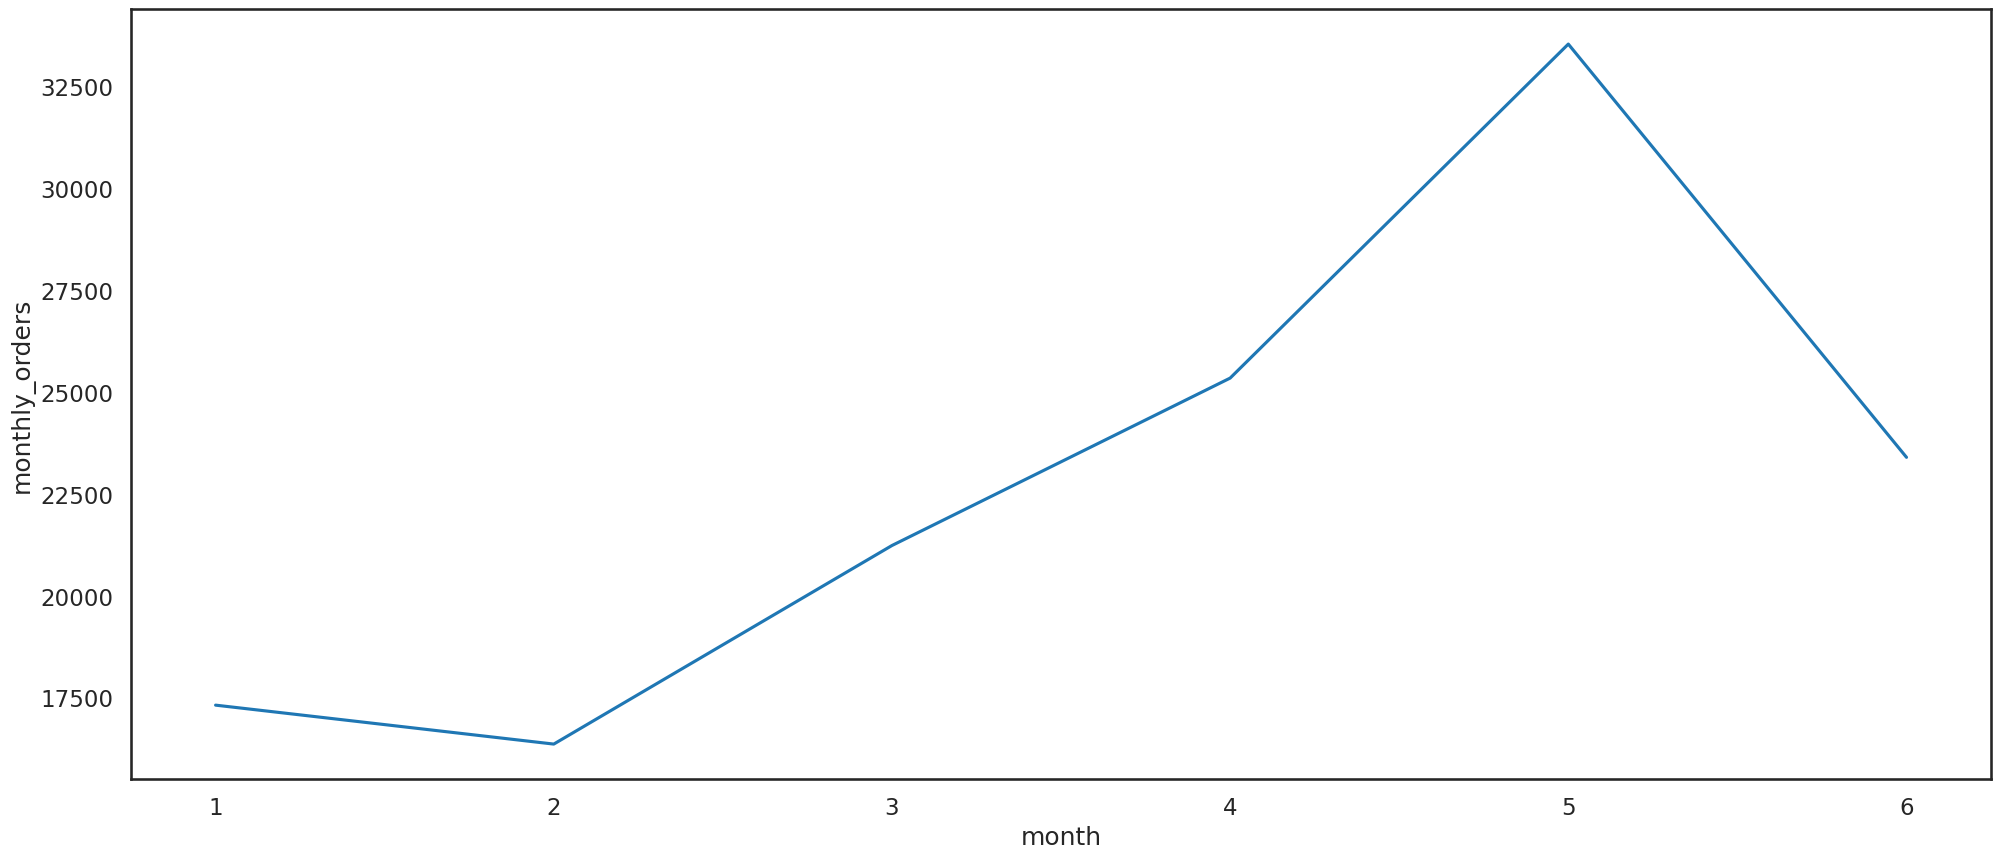

In [95]:
sns.set_context('talk')
sns.lineplot(x=monthly_orders['month'],y=monthly_orders['monthly_orders'])

In [100]:
revenue_by_category = pd.read_sql_query('''SELECT EXTRACT(month FROM transaction_date) AS month,SUM(unit_price * transaction_qty) AS revenue,product_category
FROM transactions t
JOIN products p ON p.product_id=t.product_id
GROUP BY month,product_category
ORDER BY month;''',conn)
revenue_by_category

,month,revenue,product_category
0,1.0,10406.30,Bakery
1,1.0,22621.95,Tea
2,1.0,1293.85,Loose Tea
3,1.0,521.94,Packaged Chocolate
4,1.0,1852.00,Branded
5,1.0,31362.15,Coffee
6,1.0,8337.75,Drinking Chocolate
7,1.0,974.40,Flavours
8,1.0,5249.25,Coffee beans
9,2.0,4072.00,Coffee beans
